## calculate NDJF seasonal FFDI values from Andrew Dowdy's dataset

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy as cart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
from pathlib import Path

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [2]:
#load netcdf file 
import cftime
ds = xr.open_dataset('/g/data1a/v45/du2523/FFDI_monthly_grid_1950-2020_AndrewDowdy/FFDI_monthly_grid_1950-2020.nc', decode_times = False)
ds


<xarray.Dataset>
Dimensions:    (lat: 691, lon: 886, mn: 852)
Coordinates:
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Dimensions without coordinates: mn
Data variables:
    month      (mn) int16 ...
    Mean_FFDI  (mn, lat, lon) int16 ...

In [3]:
#drop mn dimension
ds_drop = ds.drop_vars('month')
ds_drop

<xarray.Dataset>
Dimensions:    (lat: 691, lon: 886, mn: 852)
Coordinates:
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Dimensions without coordinates: mn
Data variables:
    Mean_FFDI  (mn, lat, lon) int16 ...

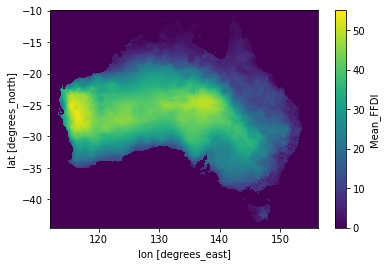

In [4]:
monthly_mean_FFDI = ds_drop.Mean_FFDI
monthly_mean_FFDI[0].plot()

In [5]:
#create a time index
#time is months since Jan 1950
dates = pd.date_range("1950-01-01",freq = "M", periods = 852)
dates_np = dates.to_numpy()
type(dates_np)

numpy.ndarray

In [6]:
#lat & lon
#type(monthly_mean_FFDI)
lats = ds.lat.values
lons = ds.lon.values

#data array
monthlyFFDI = monthly_mean_FFDI.values
#monthlyFFDI.shape

type(monthlyFFDI)

numpy.ndarray

In [7]:
#create new dataset with dates, lats, lon and Mean_FFDI array

ds_fire = xr.Dataset({
    'monthlyFFDI':xr.DataArray(
        data = monthlyFFDI, #enter data here - array must be the same size as the time, lat, lon dims/coords
        dims = ["time","lat","lon"],
        coords = {'time': dates_np,
                 'lat': lats,
                 'lon': lons},
        attrs = {
            '_FillValue':-999.9,
            'units': 'monthlymeanFFDI'
        }
    )
}
)
ds_fire

<xarray.Dataset>
Dimensions:      (time: 852, lat: 691, lon: 886)
Coordinates:
  * time         (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2020-12-31
  * lat          (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon          (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.2 156.2
Data variables:
    monthlyFFDI  (time, lat, lon) int16 0 0 0 0 0 0 ... -999 -999 -999 -999 -999

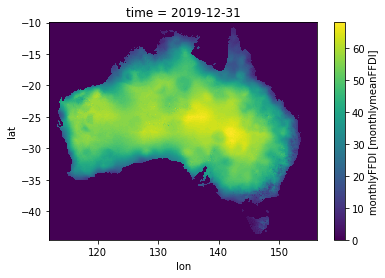

In [8]:
#ds_fire.monthlyFFDI.sel(time = '2009-02-28').plot()
ds_fire.monthlyFFDI.sel(time = '2019-12-31').plot()

In [9]:
#Subset to ice core data period (Nov1957 - Feb 2016)
FFDI_month = ds_fire.monthlyFFDI.sel(time = slice('1957-11-30','2016-02-29'))
FFDI_month.shape

#NDJF seasonal average (fire dataset already monthly) - rolling average
FFDI_4mSeason = FFDI_month.rolling(time=4).mean().dropna('time')
FFDI_4mSeason.shape

(697, 691, 886)

In [10]:
#select only February which represents NDJF FFDI average for each year
#this creates a time series of 59 seasons over Nov1957/Feb 1958 to Nov2016/Feb2017
#remember all are lablelled with February -> year will match January year of LDsss
FFDI_4mSeason_NDJF = FFDI_4mSeason.isel(time = (FFDI_4mSeason.time.dt.month == 2))
FFDI_4mSeason_NDJF.shape

(59, 691, 886)

## Load LDsss dataset

In [11]:
#load LDsss text file -> 
import pandas as pd

LDsss = pd.read_csv('/g/data1a/v45/du2523/ice_core_data/LawDome_DSS/LDsss_JanYear_1958-2016_vDec2020.csv',
                   parse_dates=['JanYear'],
                   dayfirst = True)
LDsss.head()

,JanYear,LDsss_DJFM
0,1958-01-01,0.119431
1,1959-01-01,0.029985
2,1960-01-01,0.188775
3,1961-01-01,0.134369
4,1962-01-01,0.365013


In [12]:
#set up parameters
LDsss_dates_col = LDsss.loc[:,'JanYear']
LDsss_dates = LDsss_dates_col.values
#LDsss_dates

LDsss_conc_col = LDsss.loc[:,'LDsss_DJFM']
LDsss_conc = LDsss_conc_col.values
#LDsss_conc
LDsss_conc.size


59

In [13]:
#parameters to replicate LDsss dataset
nlons = lons.size
nlats = lats.size
ntime = LDsss_dates.size

LDsss_arr = np.zeros((ntime,nlats,nlons))
LDsss_arr.shape

(59, 691, 886)

In [14]:
LDsss_arr = np.zeros((ntime,nlats,nlons))
LDsss_fill = np.zeros((ntime,nlats,nlons))
#LDsss_fill[[0]].shape

n = LDsss_dates.size
for i in range(n):
    x = LDsss_conc[i]
    tmp = LDsss_arr[i,:,:]
    tmp[tmp == 0] = x
    LDsss_fill[[i]] = tmp

LDsss_fill.shape
#LDsss_fill[58,:,:] #final timestep

(59, 691, 886)

In [22]:
#dates - extract from FFDI_4mSeason_NDJF
dates_LDsss = FFDI_4mSeason_NDJF.time.values
dates_LDsss.shape
dates_LDsss

array(['1958-02-28T00:00:00.000000000', '1959-02-28T00:00:00.000000000',
       '1960-02-29T00:00:00.000000000', '1961-02-28T00:00:00.000000000',
       '1962-02-28T00:00:00.000000000', '1963-02-28T00:00:00.000000000',
       '1964-02-29T00:00:00.000000000', '1965-02-28T00:00:00.000000000',
       '1966-02-28T00:00:00.000000000', '1967-02-28T00:00:00.000000000',
       '1968-02-29T00:00:00.000000000', '1969-02-28T00:00:00.000000000',
       '1970-02-28T00:00:00.000000000', '1971-02-28T00:00:00.000000000',
       '1972-02-29T00:00:00.000000000', '1973-02-28T00:00:00.000000000',
       '1974-02-28T00:00:00.000000000', '1975-02-28T00:00:00.000000000',
       '1976-02-29T00:00:00.000000000', '1977-02-28T00:00:00.000000000',
       '1978-02-28T00:00:00.000000000', '1979-02-28T00:00:00.000000000',
       '1980-02-29T00:00:00.000000000', '1981-02-28T00:00:00.000000000',
       '1982-02-28T00:00:00.000000000', '1983-02-28T00:00:00.000000000',
       '1984-02-29T00:00:00.000000000', '1985-02-28

In [16]:
ds_icecore = xr.Dataset({
    'LDsss':xr.DataArray(
        data = LDsss_fill, #enter data here - array must be the same size as the time, lat, lon dims/coords
        dims = ["time","lat","lon"],
        coords = {'time': dates_LDsss,
                 'lat': lats,
                 'lon': lons},
        attrs = {
            '_FillValue':-999.9,
            'units': 'logCl'
        }
    )
}
)
ds_icecore

<xarray.Dataset>
Dimensions:  (time: 59, lat: 691, lon: 886)
Coordinates:
  * time     (time) datetime64[ns] 1958-02-28 1959-02-28 ... 2016-02-29
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Data variables:
    LDsss    (time, lat, lon) float64 0.1194 0.1194 0.1194 ... 0.3387 0.3387

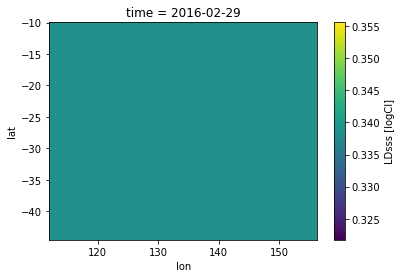

In [17]:
# plot to visualise - LDsss value replicated across all grid points of the netcdf file
ds_icecore.LDsss.sel(time = '2016-02-29').plot()

## Detrend (Linear)

In [18]:
#Detrend function

def detrend_dim(da, dim, deg = 1):
    #detrend along a single dimension
    p = da.polyfit(dim = dim, deg = deg)
    fit = xr.polyval(da[dim],p.polyfit_coefficients)
    return da - fit


In [19]:
#detrend FFDI
dFFDI_4mSeason_NDJF = detrend_dim(FFDI_4mSeason_NDJF, 'time',1)

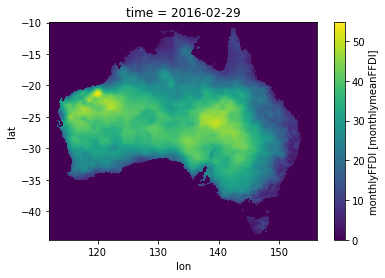

In [23]:
FFDI_4mSeason_NDJF.sel(time = '2016-02-29').plot()

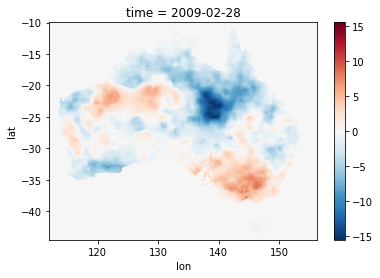

In [39]:
dFFDI_4mSeason_NDJF.sel(time = '2009-02-28').plot()

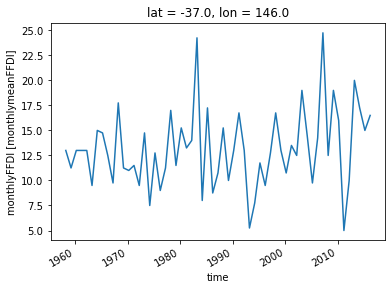

In [40]:
#lat/lon slice 
FFDI_4mSeason_NDJF.sel(lat=-37,lon=146).plot()

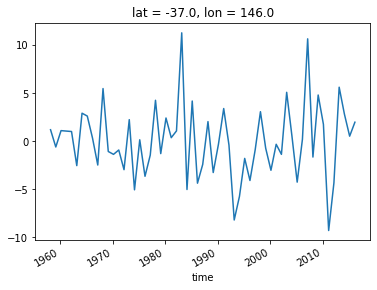

In [41]:
dFFDI_4mSeason_NDJF.sel(lat=-37,lon=146).plot()

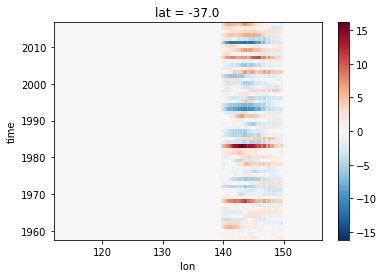

In [44]:
dFFDI_4mSeason_NDJF.sel(lat=-37).plot()

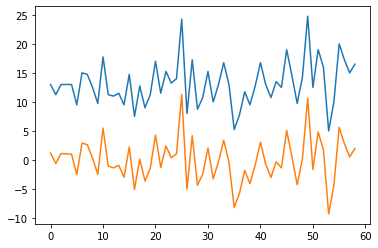

In [74]:
#FFDI
FFDI_trend = FFDI_4mSeason_NDJF.sel(lat=-37,lon=146)
FFDI_detrend = dFFDI_4mSeason_NDJF.sel(lat=-37,lon=146)
plt.plot(FFDI_trend)
plt.plot(FFDI_detrend)

In [45]:
#LDsss
#extract data array from the new dataset (needs to be data array not dataset for correlation to work)
LDsss = ds_icecore.LDsss
#LDsss.shape

#calculate detrending using fucntion defined above
dLDsss = detrend_dim(LDsss, 'time',1)

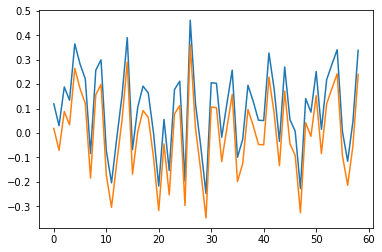

In [73]:
LDsss_trend = LDsss.sel(lat=-37,lon=146)
LDsss_detrend = dLDsss.sel(lat=-37,lon=146)
plt.plot(LDsss_trend)
plt.plot(LDsss_detrend)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

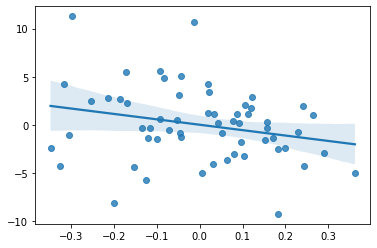

In [79]:
#scatter
import seaborn as sns
x = LDsss_detrend
y = FFDI_detrend

#create scatterplot with Seaborn 
sns.regplot(x,y)


In [ ]:
plt.scatter(LDsss_detrend,FFDI_detrend)

#obtain m(slope) and b(intercept) of linear regression line
m,b = np.polyfit(LDsss_detrend, FFDI_detrend , 1)

#add linear regression line to scatterplot
plt.plot(LDsss_detrend,m*LDsss_detrend+b)

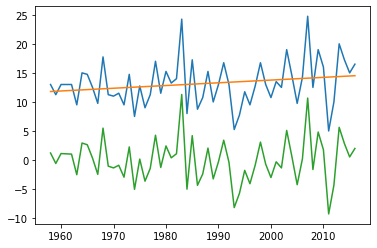

In [126]:
x = np.arange(1958,2017)
y = FFDI_4mSeason_NDJF.sel(lat=-37,lon=146).values

plt.plot(x,y)
p = np.polyfit(x,y,1)
fit = np.polyval(p,x)
plt.plot(x, fit)
y_detrend = y - fit
plt.plot(x,y_detrend)

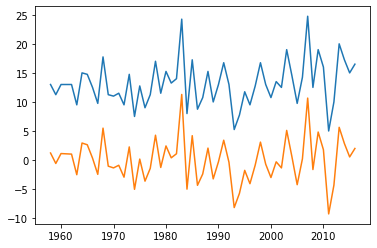

In [127]:
plt.plot(x,y)
plt.plot(x,y_detrend)

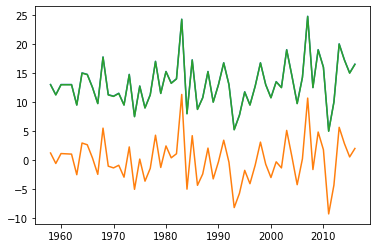

In [130]:
#plt.plot(x,y,'o')
slope,intercept = np.polyfit(x,y,1)
#plt.plot(x,slope*x+intercept)

slope_fit = y - slope
plt.plot(x,y)
plt.plot(x,y_detrend)
plt.plot(x,slope_fit)


## Correlation

In [138]:
#check datatypes are correct (data array) for correlation
#type(LDsss)
type(dFFDI_4mSeason_NDJF)

xarray.core.dataarray.DataArray

In [139]:
type(dLDsss)

xarray.core.dataarray.DataArray

In [142]:
#run the correlation - assign results to a new variable called corr
#this step can take a while to run
corr = xr.corr(LDsss,FFDI_4mSeason_NDJF,dim="time")
dcorr = xr.corr(dLDsss,dFFDI_4mSeason_NDJF,dim = "time")

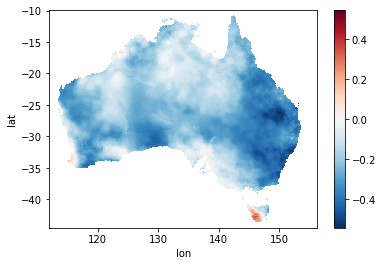

In [143]:
corr.plot()

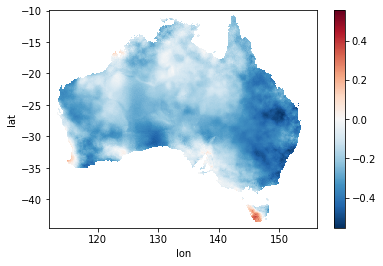

In [144]:
dcorr.plot()

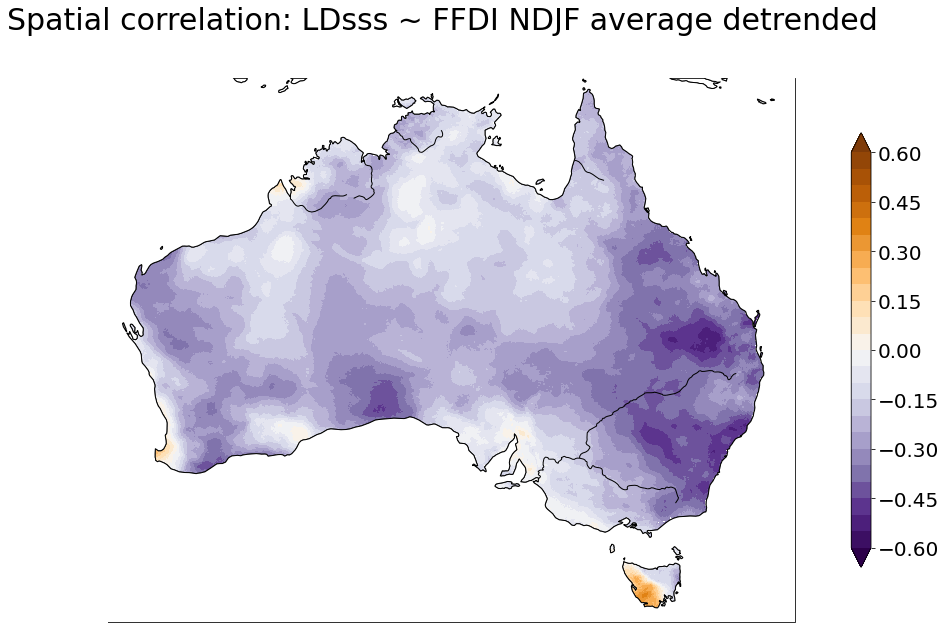

In [149]:
#Set up figure and save as jpg
output = '/g/data/v45/du2523/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

levels = np.arange(-0.6,0.65,0.05)
#ID = 'LDsss_FFDI_corr'
ID = 'LDsss_FFDI_corr_detrend'
region = 'Aus_NDJF'

#either corr or dcorr
cp = dcorr.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'both',
                        cmap = 'PuOr_r',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
    
        
fig.suptitle('Spatial correlation: LDsss ~ FFDI NDJF average detrended',fontsize = 30)
 
#save figure
fig.savefig(output + ID + '_' + region  +'.jpg')

plt.show()

In [146]:
#calculate signficance of correlation 
from scipy import stats
#degrees of freedom (sample size - number of parameters)

sample_size = ntime
degF = sample_size - 2

sig = xr.DataArray(data = corr.values*np.sqrt((ntime-2)/1-np.square(corr.values)),
                   dims = ["lat","lon"],
                   coords = [corr.lat,corr.lon])
t90 = stats.t.ppf(1-0.05, ntime-2)
t95 = stats.t.ppf(1-0.025, ntime-2)   

#detrend signficance

dsig = xr.DataArray(data = dcorr.values*np.sqrt((ntime-2)/1-np.square(dcorr.values)),
                   dims = ["lat","lon"],
                   coords = [dcorr.lat,dcorr.lon])
 

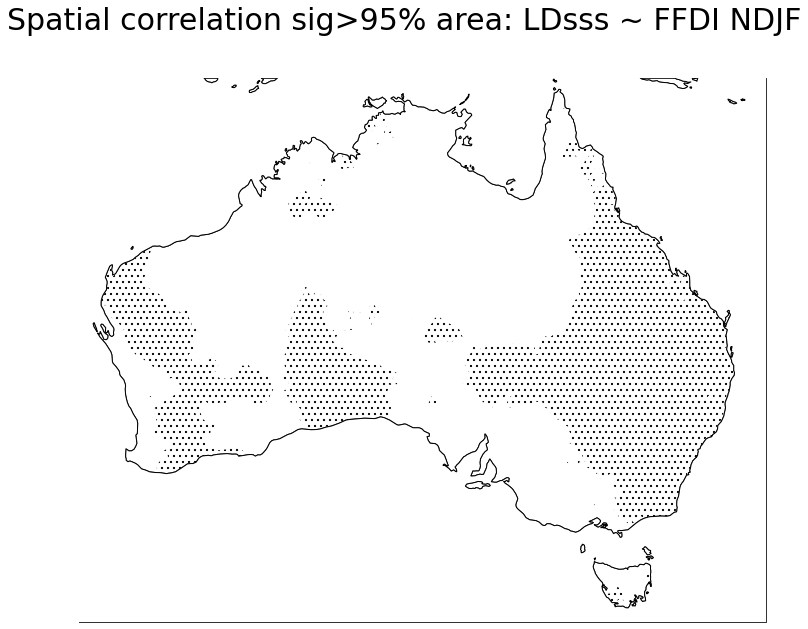

In [147]:
#signficance region figure

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

#ID = 'LDsss_FFDI_corr_sigHatch'
ID = 'LDsss_FFDI_corr_detrend_sigHatch'
region = 'Aus_NDJF'

#either sig or dsig
sig_hatch = dsig.plot.contourf(ax = ax,
                 levels = [-1*t95,-1*t90,t90,t95],
                 colors = 'none',
                 hatches = ['..',None,None,None,'..'],
                 extend = 'both',
                 add_colorbar = False,
                 transform = ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')

fig.suptitle('Spatial correlation sig>95% area: LDsss ~ FFDI NDJF',fontsize = 30)
fig.savefig(output + ID + '_' + region  +'.jpg')

plt.show()

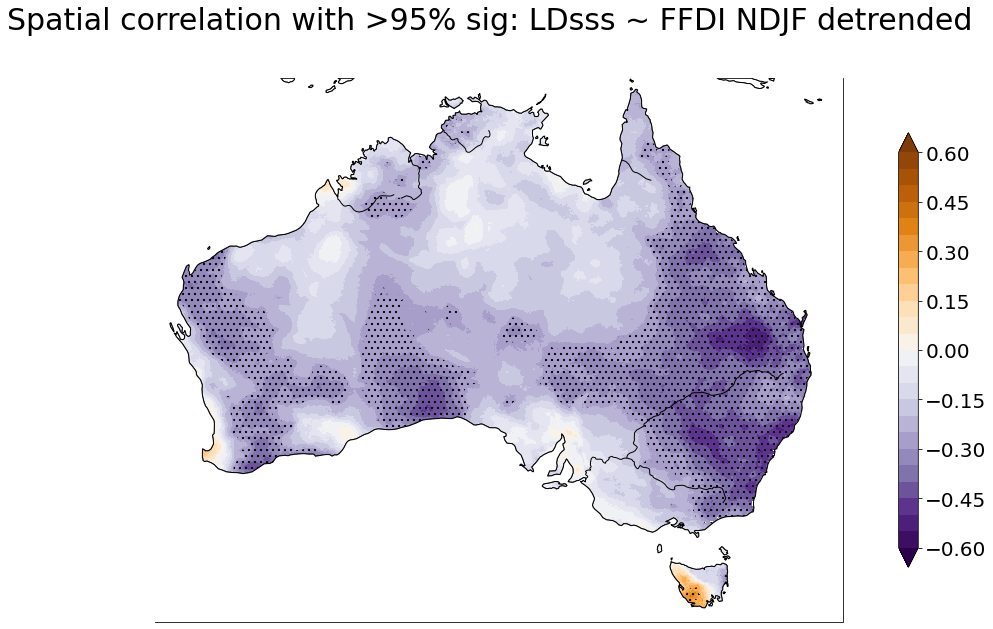

In [148]:
#Plot correlation results with significance shaded
#add mask over central Aus

#signficance calculation above

output = '/g/data/v45/du2523/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

levels = np.arange(-0.6,0.65,0.05)
#ID = 'LDsss_FFDI_corr_sig'
ID = 'LDsss_FFDI_corr_detrend_sig'
region = 'Aus_NDJF'

#either corr or dcorr

cp = dcorr.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'both',
                        cmap = 'PuOr_r',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)

#either sig or dsig                      
sig_hatch = dsig.plot.contourf(ax = ax,
                 levels = [-1*t95,-1*t90,t90,t95],
                 colors = 'none',
                 hatches = ['..',None,None,None,'..'],
                 extend = 'both',
                 add_colorbar = False,
                 transform = ccrs.PlateCarree())
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
    
fig.suptitle('Spatial correlation with >95% sig: LDsss ~ FFDI NDJF detrended',fontsize = 30)
 
#save figure
fig.savefig(output + ID + '_' + region  +'.jpg')

plt.show()

## Regression 

In [151]:
reg0 = xr.cov(LDsss,FFDI_4mSeason_NDJF,dim="time")/LDsss.var(dim = "time", skipna = True).values
dreg0 = xr.cov(dLDsss,dFFDI_4mSeason_NDJF,dim="time")/dLDsss.var(dim = "time", skipna = True).values

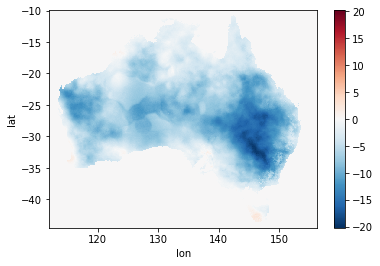

In [152]:
reg0.plot()

In [165]:
maxv = dreg0.max().values
minv = dreg0.min().values

import matplotlib.colors as mcolors

#create normalisation to be applied to colorbar
divnorm = mcolors.TwoSlopeNorm(vmin = minv, vcenter = 0, vmax = maxv)

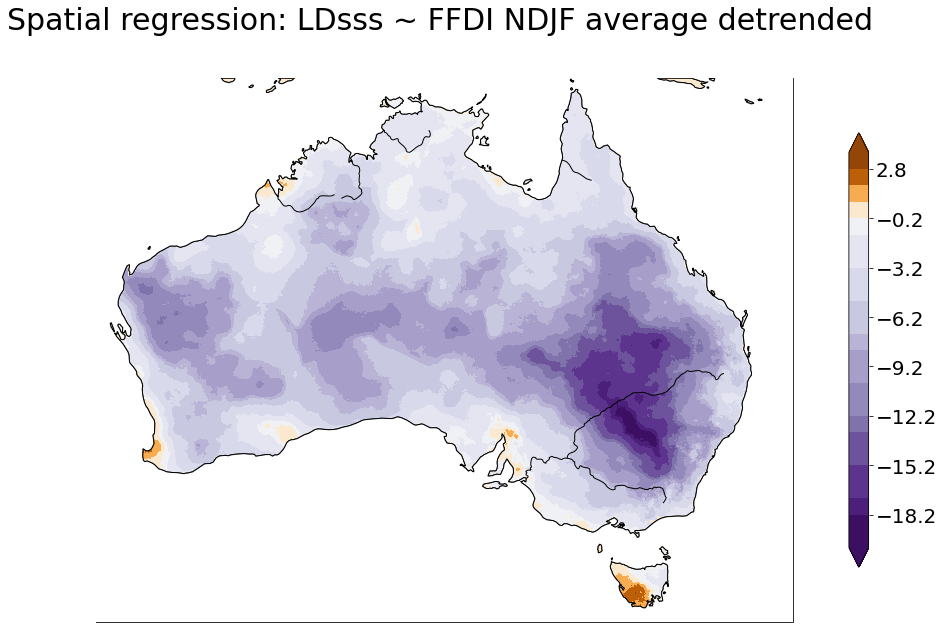

In [166]:
## Regression plot
output = '/g/data/v45/du2523/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

levels = np.arange(minv,maxv+1)
ID = 'LDsss_FFDI_regression_detrend'
region = 'Aus_NDJF'

cp = dreg0.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'both',
                        cmap = 'PuOr_r',
                        norm = divnorm,
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
    
        
fig.suptitle('Spatial regression: LDsss ~ FFDI NDJF average detrended',fontsize = 30)
 
#save figure
fig.savefig(output + ID + '_' + region  +'.jpg')

plt.show()